In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from load_data import retrieve_dataset, retrieve_spike_lists
from tools.analysis.signals import SpikeList, StateMatrix
from tools.visualization import helper

In [3]:
# Retrieve the dataset from the remote directory (or load if available locally)
base_url = "https://zenkelab.org/datasets"
data_path = "./data"
hdf5_file_path = retrieve_dataset(base_url, data_path)


n_samples = 10  # How many spoken digits to analyse
n_units = 100   # How many cochlear neurons to load
data_samples = retrieve_spike_lists(hdf5_file_path, n_samples, n_units)

Using cache dir: ./data


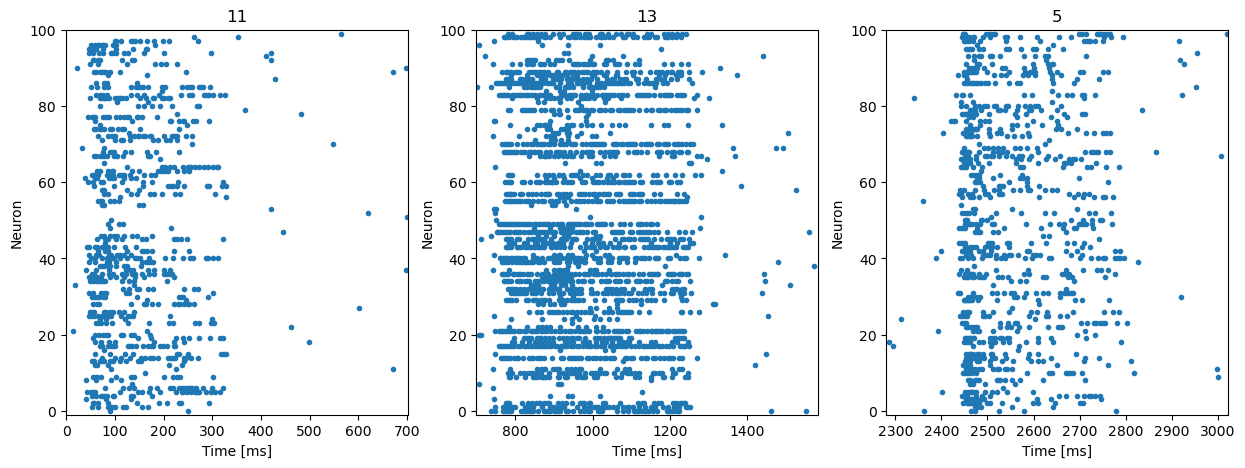

In [4]:
# Each data sample is a tuple containing (label, (t_start, t_stop), spike_list)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for axis, sample in zip(ax, data_samples[:3]):
    sample[2].raster_plot(ax=axis, display=False)
    axis.set_title(sample[0])
    axis.set_xlabel('Time [ms]')
    axis.set_ylabel('Neuron')

In [5]:
# Low-pass filter spiking activity
dt = 0.1
tau = 20.

response_matrices = []
labels = []
for idx, sample in enumerate(data_samples):
    state_matrix = sample[2].filter_spiketrains(dt=0.1, tau=tau)
    sm = StateMatrix(state_matrix, 'sample_{}'.format(idx), 'spikes', 'cochlea', dataset_label=sample[0], standardize=False)
    response_matrices.append(sm)
    labels.append(np.repeat(sample[0], state_matrix.shape[1]))


Compiling activity matrix from SpikeList


100%|██████████| 100/100 [00:01<00:00, 57.06it/s]



Compiling activity matrix from SpikeList


100%|██████████| 100/100 [00:02<00:00, 33.77it/s]



Compiling activity matrix from SpikeList


100%|██████████| 100/100 [00:02<00:00, 38.94it/s]



Compiling activity matrix from SpikeList


100%|██████████| 100/100 [00:02<00:00, 38.69it/s]



Compiling activity matrix from SpikeList


100%|██████████| 100/100 [00:02<00:00, 43.49it/s]



Compiling activity matrix from SpikeList


100%|██████████| 100/100 [00:02<00:00, 43.80it/s]



Compiling activity matrix from SpikeList


100%|██████████| 100/100 [00:02<00:00, 47.47it/s]



Compiling activity matrix from SpikeList


100%|██████████| 100/100 [00:02<00:00, 35.81it/s]



Compiling activity matrix from SpikeList


100%|██████████| 100/100 [00:05<00:00, 19.60it/s]



Compiling activity matrix from SpikeList


100%|██████████| 100/100 [00:04<00:00, 23.57it/s]


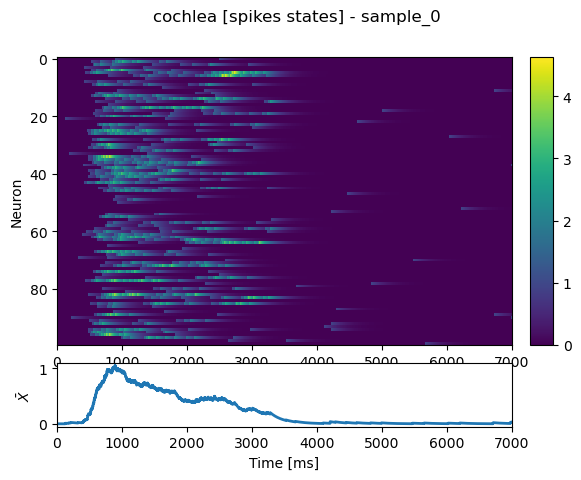

[states.py:336 - INFO] Explained Variance (first 3 components): [0.54544554 0.1748413  0.0738222 ]
[states.py:44 - INFO] Determining effective dimensionality...
[states.py:57 - INFO] Effective dimensionality = 2.97
[states.py:58 - INFO] Elapsed Time: 0.0 s


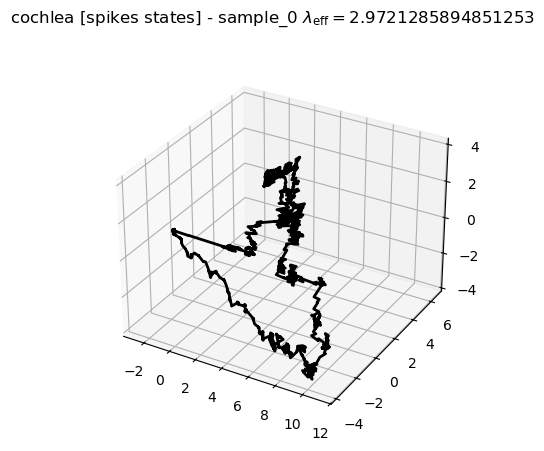

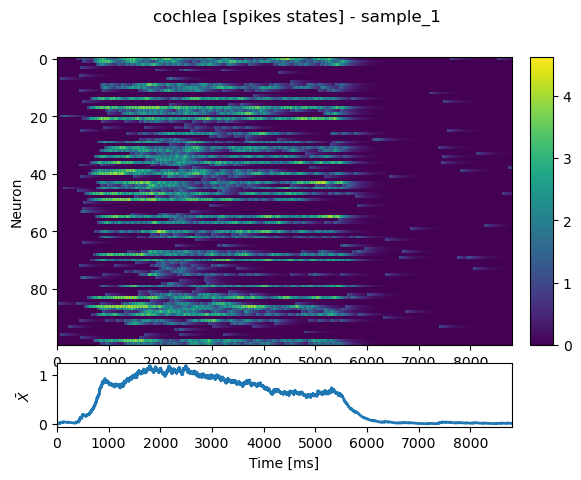

[states.py:336 - INFO] Explained Variance (first 3 components): [0.68987165 0.06629646 0.03864748]
[states.py:44 - INFO] Determining effective dimensionality...
[states.py:57 - INFO] Effective dimensionality = 2.07
[states.py:58 - INFO] Elapsed Time: 0.0 s


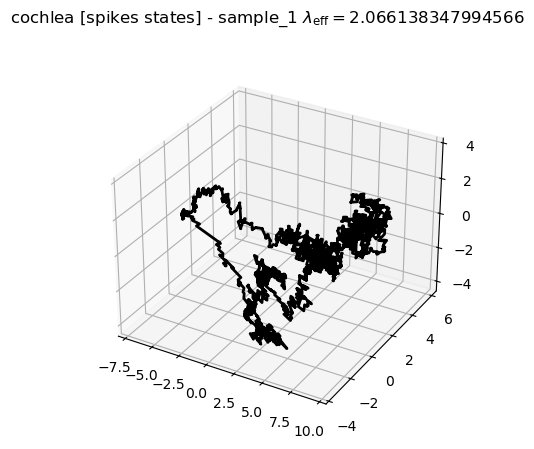

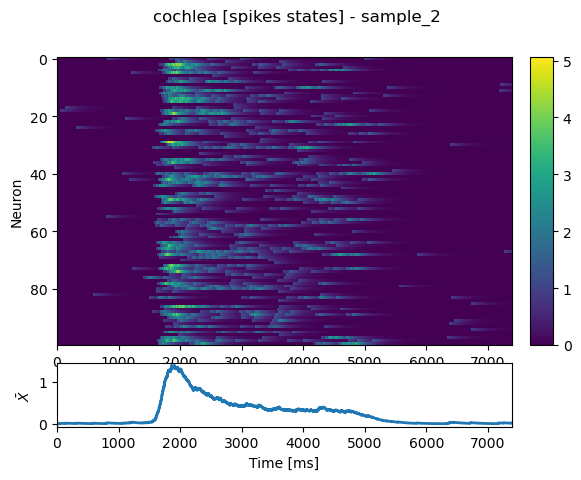

[states.py:336 - INFO] Explained Variance (first 3 components): [0.59924193 0.09239706 0.05185569]
[states.py:44 - INFO] Determining effective dimensionality...
[states.py:57 - INFO] Effective dimensionality = 2.67
[states.py:58 - INFO] Elapsed Time: 0.0 s


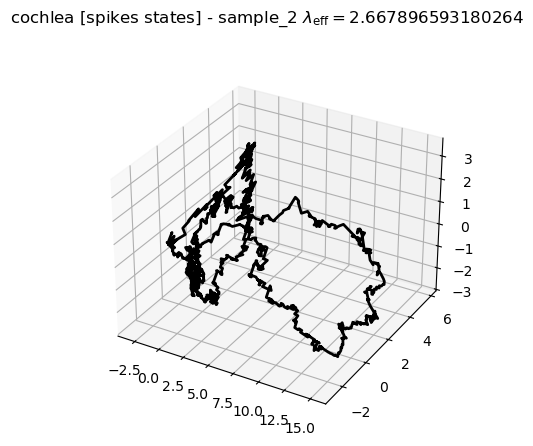

In [6]:
for axis, sample in zip(ax, response_matrices[:3]):
    sample.plot_matrix()
    sample.plot_trajectory()

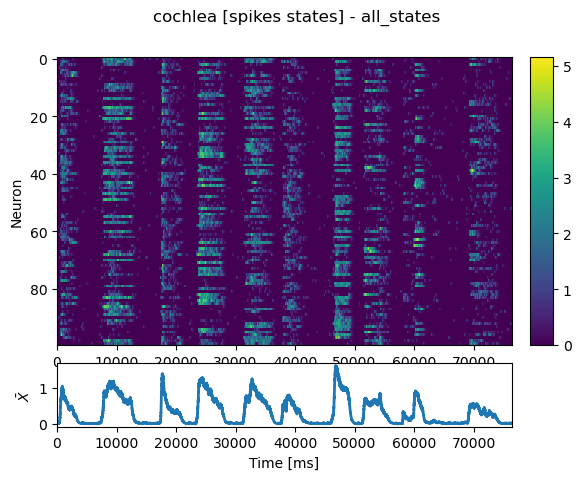

In [7]:
# Now we need to concatenate all responses
all_states = np.concatenate([x.matrix for x in response_matrices], axis=1)
all_labels = np.concatenate(labels)
global_state_matrix = StateMatrix(all_states, 'all_states', 'spikes', 'cochlea', standardize=False)
global_state_matrix.plot_matrix()
# state matrices comprise (n_features x n_samples)

In [11]:
# We are looking for the geometry of population dynamics, i.e., how state vectors organize.. It is wise to simplify the analysis using less sampled states
subsampled_state = all_states[:, ::10]
subsampled_labels = all_labels[::10]


In [12]:
# Principal Component Analysis
from sklearn.decomposition import PCA

pca_obj = PCA(n_components=3)
X_r = pca_obj.fit_transform(subsampled_state.T)

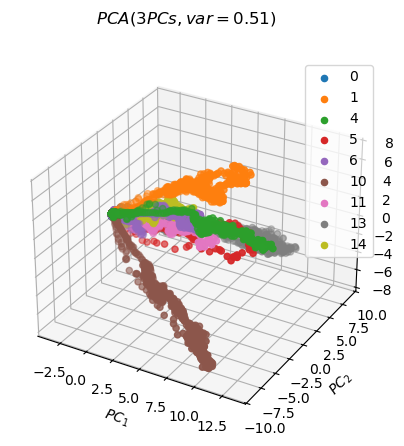

In [13]:
fig = plt.figure()
exp_var = np.sum([round(n, 2) for n in pca_obj.explained_variance_ratio_])
fig.suptitle(r'$PCA (3 PCs, var = {})$'.format(str(exp_var)), fontsize=12)
ax = fig.add_subplot(111, projection='3d')
colors_map = helper.get_cmap(N=len(np.unique(subsampled_labels)), cmap='Paired')
ax.set_xlabel(r'$PC_{1}$')
ax.set_ylabel(r'$PC_{2}$')
ax.set_zlabel(r'$PC_{3}$')

for lab in np.unique(subsampled_labels).astype(int):
    ax.scatter(X_r[np.where(subsampled_labels == lab)[0], 0], X_r[np.where(subsampled_labels == lab)[0], 1], 
               X_r[np.where(subsampled_labels == lab)[0], 2], s=20, label=lab)
plt.legend(loc=0)